In [1]:
from emulator_utils.pre_process import log_standard, minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp, mcdrop_pred

In [2]:
import matplotlib.pylab as plt
import numpy as np

In [3]:
# dirIn = '../test/data/sps_ugrizy/'
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/'

mags = np.load(dirIn + 'colors.npy')
ebv = np.load(dirIn + 'ebv.npy')
redshift = np.load(dirIn + 'redshift.npy')
sfh = np.load(dirIn + 'sfh.npy')

In [4]:
sps_inputs = np.concatenate((redshift[np.newaxis, :], ebv[np.newaxis, :], sfh.T), axis=0).T

In [5]:
scaled, scaler = minmax(sps_inputs)

In [6]:
scaled_y, scaler_y = minmax(mags)

In [7]:
param_train, param_test, mag_train, mag_test = random_holdout(scaled, scaled_y, split_fraction = 0.1)

In [8]:
param_train.shape, mag_train.shape

((9000, 180), (9000, 6))

In [9]:
mlp = simple_mlp(input_shape=param_train.shape[1], 
                 output_shape=mag_train.shape[1], 
                 hidden_dims=[256, 1024, 512, 64])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               46336     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                3

### Setting Hyper-parameters

In [10]:
learning_rate = 0.01
decay_rate = 0.1
batch_size = 128
num_epochs = 50

In [11]:
mlp, train_history = train_mlp(mlp, 
                    # param_train, pk_train, param_test, pk_test, 
                    param_train, mag_train, param_test, mag_test,
                    learning_rate, decay_rate, num_epochs, batch_size);

Training complete
Test loss after training: 0.001


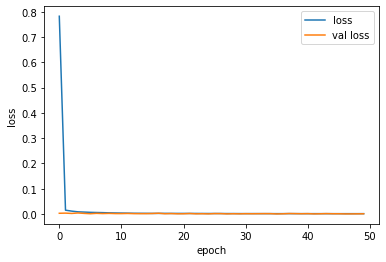

In [12]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [13]:
save_mlp(mlp, '../test/model/phot_mlp')
mlp = load_mlp('../test/model/phot_mlp')

2022-04-30 13:01:03.372298: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../test/model/phot_mlp/assets
Model saved at: ../test/model/phot_mlp
Model loaded from: ../test/model/phot_mlp


In [14]:
mlp_pred = mlp.predict(param_test)
color_pred = unscale(mlp_pred, scaler_y)

In [15]:
def color_forward(param_in):
    redshift_in = param_in[:, 0]
    ebv_in = param_in[:, 1]

    sfh_in = sfh[507][np.newaxis, :]
    sfh_in = np.tile(sfh_in, (ebv_in.shape[0], 1))

    input_params = np.concatenate( (redshift_in.reshape(-1, 1), 
                                    ebv_in.reshape(-1, 1), 
                                    sfh_in) , axis=1)

    sps_in = scaler.transform(input_params)

    mlp_pred = mlp.predict(sps_in)
    mags_pred = unscale(mlp_pred, scaler_y)
    
    cols = mags_pred[:, :-1] - mags_pred[:, 1:]
    cols_magi = np.concatenate( (cols, mags_pred[:, 3][:, np.newaxis]), axis=1)
    
    return cols_magi

In [19]:
# from tensorflow.python.keras.backend import eager_learning_phase_scope
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model


# def _mcdrop_pred(model, sps_in):
#     mc_samples = 1000
#     # f = K.function([model.layers[0].input], [model.output])
#     partial_model = Model(model.layers[0].input, model.output)

    
#     # Run the function for the number of mc_samples with learning_phase enabled
#     # with eager_learning_phase_scope(value=1): # 0=test, 1=train
#         # Yt_hat = np.array([ unscale(f((sps_in))[0], scaler_y) for _ in range(mc_samples) ])

#     # embedding = partial_model(sps_in, training=True)
#     Yt_hat = np.array( [  unscale(partial_model(sps_in, training=True), scaler_y) for _ in range(mc_samples)] )
    
#     y_mean = np.mean(Yt_hat, axis=0)
#     y_std = np.std(Yt_hat, axis=0)
    
#     return Yt_hat





def prob_color(param_in):
    
    '''
    This provides p(colors|redshift, dust). But SFH is chosen (arbitrarily). 
    
    '''
    redshift_in = param_in[:, 0]
    ebv_in = param_in[:, 1]
    
    
    sfh_id = 10
    sfh_in = sfh[sfh_id][np.newaxis, :]
    sfh_in = np.tile(sfh_in, (ebv_in.shape[0], 1))

    input_params = np.concatenate( (redshift_in.reshape(-1, 1), 
                                    ebv_in.reshape(-1, 1), 
                                    sfh_in) , axis=1)

    # sps_in = scaler.transform(input_params)
  
    #############
    
    # mlp_pred = mlp.predict(sps_in)
    
    mags_pred, _, _ = mcdrop_pred(input_params, mlp, scaler, scaler_y)
    # print(mags_pred.shape)
    
    #############  
    
    # mags_pred = unscale(mlp_pred, scaler_y)
    
    cols = mags_pred[:, :, :-1] - mags_pred[:, :, 1:]
    # print(cols.shape, mags_pred[:, :, 3][:, :, np.newaxis].shape)
    cols_magi = np.concatenate( (cols, mags_pred[:, :, 3][:, :, np.newaxis]), axis=2)
    # print(cols_magi[0, 0])
    return cols_magi


In [20]:
param_train_unscaled = unscale(param_train, scaler)
param_test_unscaled = unscale(param_test, scaler)

pcolor = prob_color(param_test_unscaled)
mean_color = color_forward(param_test_unscaled)

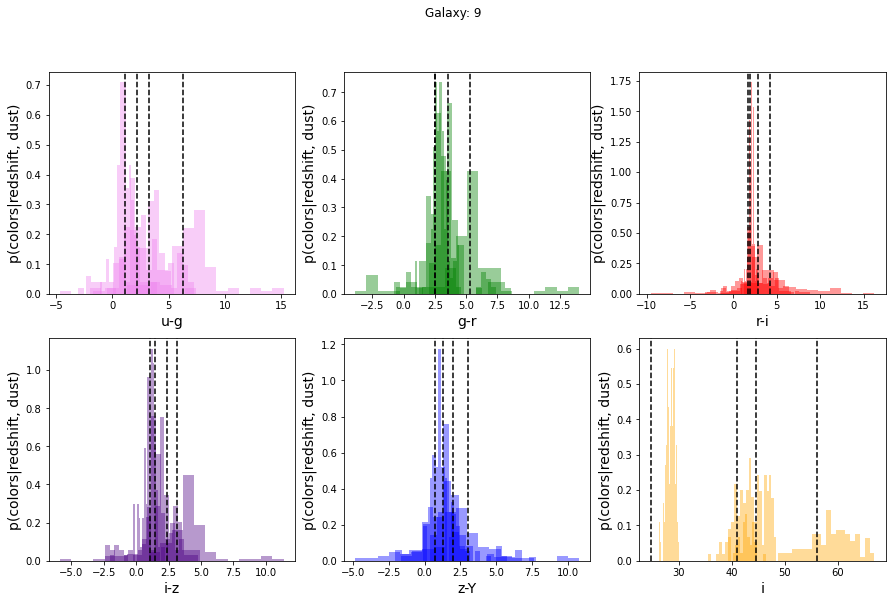

In [24]:
colors = ['violet', 'green', 'red', 'indigo', 'blue', 'orange']
target_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-Y', 'i']

mag_test_unscale = unscale(mag_test, scaler_y)
cols_test = mag_test_unscale[:, :-1] - mag_test_unscale[:, 1:]
cols_magi_test = np.concatenate( (cols_test, mag_test_unscale[:, 3][:, np.newaxis]), axis=1)
# target_truths = unscale(cols_test, scaler_y)

f, a = plt.subplots(2,3, figsize=(15, 9))

for galID in range(6, 10):
    f.suptitle('Galaxy: %d'%galID)
    for bandID in range(6):
        a[int(bandID/3),bandID%3].hist(pcolor[:, galID, bandID], bins = 20, histtype='stepfilled', density = True, 
                                       color=colors[bandID], alpha=0.4, lw=2);
        a[int(bandID/3),bandID%3].set_xlabel(target_labels[bandID], fontsize=14)
        a[int(bandID/3),bandID%3].set_ylabel('p(colors|redshift, dust)', fontsize=14)
        a[int(bandID/3),bandID%3].axvline( cols_magi_test[galID, bandID], color='k', linestyle='dashed')
        # print(color_test[galID, bandID])
        # print(4*'====')      

### Local explainers

In [25]:
from emulator_utils.explainers import shap_estimate
from emulator_utils.explainers import plot_shap_summary_single, plot_shap_summary_multiple
from emulator_utils.explainers import plot_shap_force_single, plot_shap_force_multiple
from emulator_utils.explainers import global_explainer

In [26]:
param_train_unscaled = unscale(param_train, scaler)[:,0:2]
param_test_unscaled = unscale(param_test, scaler)[:,0:2]

input_labels = ['redshift', 'dust']
# target_labels_mags = ['u', 'g', 'r', 'i', 'z', 'y']


# explainer, shap_values, expected_values = shap_estimate(color_forward, 
#                                                         param_train_unscaled, param_test_unscaled, 
#                                                         input_labels, target_labels) ### slow

explainer, shap_values, expected_values = shap_estimate(color_forward, 
                                                        param_test_unscaled, param_test_unscaled, 
                                                        input_labels, target_labels)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
np.array(shap_values).shape

(6, 1000, 2)

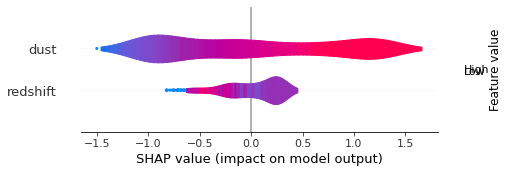

In [28]:
output_indx = 2
plot_shap_summary_single(shap_values[output_indx], param_test_unscaled, input_labels, target_labels[output_indx], plot_type='violin')

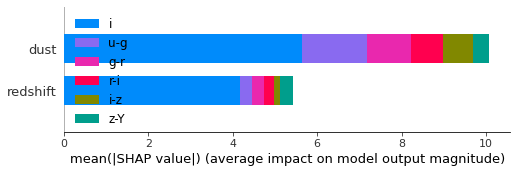

In [29]:
plot_shap_summary_multiple(shap_values, param_test_unscaled, input_labels, target_labels, plot_type='bar')

In [38]:
bandID = 5
plot_shap_force_multiple(expected_values, shap_values, input_labels, target_labels, out_id = bandID)

In [31]:
plot_shap_force_single(expected_values, shap_values, input_labels, target_labels, out_id = 0, test_id=10)

In [32]:
plot_shap_force_single(expected_values, shap_values, input_labels, target_labels, out_id = 1, test_id=10)

In [33]:
plot_shap_force_single(expected_values, shap_values, input_labels, target_labels, out_id = 3, test_id=10)

In [34]:
plot_shap_force_single(expected_values, shap_values, input_labels, target_labels, out_id = 4, test_id=10)

In [35]:
plot_shap_force_single(expected_values, shap_values, input_labels, target_labels, out_id = 5, test_id=10)

### Global explainer

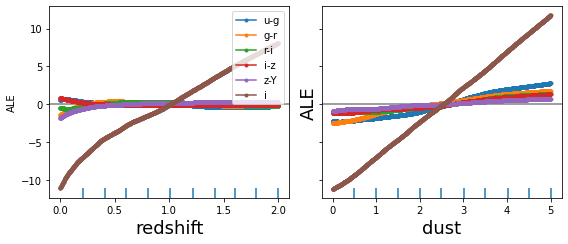

In [36]:
global_explainer(color_forward, param_train_unscaled, param_test_unscaled, input_labels, target_labels);